In [1]:
# test realtime pose CLASSIFICATION (and hence landmark detection...)
# on our curated dataset of pose videos

import sys
sys.path.insert(0, '/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/training_pipeline')
import os
import cv2
import mediapipe as mp
import pickle
from extract_features import FeaturesMP
import numpy as np
import time
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from collections import Counter

# Retrieve pre-trained model
mp_model_path = "/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/pretrained_models/pose_landmarker_full.task"
# Initialize FeaturesMP object
features_mp = FeaturesMP(mp_model_path, image_size=(1080, 1920))
# load the label encoder
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/training_pipeline/label_encoder.pkl', 'rb') as f:    
    label_encoder = pickle.load(f)

# NOT SURE IF 7 OR 8 BUT ONE OF THOSE
# load the trained classifier
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/padded_nn_7.pkl', 'rb') as f:
    classifier = pickle.load(f)
    
# load the sanskrit to english dictionary
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/sanskrit_english_dict.pkl', 'rb') as f:
    sanskrit_english_dict = pickle.load(f)


# function to write demonstration videos - rest of testing function is sent in test_video.py

def test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict):

    cap = cv2.VideoCapture(video_path)

    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    n = -1

    # introduce delay in position predictions
    buffer = [-1,-1,-1,-1]

    label_across_frames = []
    label_with_delays = []

    # Initialize detector
    features_mp.init_detector(video=True, min_pose_detection_confidence=0.7)

    # Create a loop to read the latest frame from the camera
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("Error: Unable to fetch the frame or finished the video.")
            break
        
        # new frame
        n+=1
        # get timestamp from frame rate
        timestamp = int(n * 1000 / frame_rate)

        # Run inference on the image 
        landmarks = features_mp.detect(frame, video=True, frame_timestamp_ms=timestamp)
        
        # Draw landmarks if detected
        if landmarks is not None:
            if len(landmarks.pose_landmarks) != 0:
                
                pose_landmarks_list = landmarks.pose_landmarks 

                # get only normalized coordinates - improves latency
                pose_landmarks = pose_landmarks_list[0]

                to_classify = np.zeros((features_mp.n_landmarks, 4))
                to_extend = []
                
                # store normalized landmarks to appends and classify
                for k, landmark in enumerate(pose_landmarks):
                    to_classify[k] = [landmark.x, landmark.y, landmark.z, landmark.visibility]
                    
                # normalize and rotate to_classify
                to_classify = features_mp.make_rot_invariant_partial(to_classify, init_norm=True)
                to_classify = to_classify.reshape(1, features_mp.n_landmarks * 4)
                    
                # Run inference
                predicted_class = classifier.predict(to_classify)
                # Get the string label
                predicted_name = label_encoder.inverse_transform([int(predicted_class-1)])
                english = sanskrit_english_dict[predicted_name[0]]
                label_across_frames.append(english)
                # Append to buffer
                buffer.pop(0)
                buffer.append(predicted_name[0])
                # # if all elements now in the buffer are the same, then we can display the pose
                if buffer[0] == buffer[1] == buffer[2] == buffer[3]:
                    text = english
                    label_with_delays.append(english)

    # Release resources
    cap.release()
    # out.release()
    cv2.destroyAllWindows()
    
    return label_across_frames, label_with_delays


In [ ]:

# MISSING ARDHA MATS, ardha pincha, ashta chandra

testing_now = ['Adho Mukha Svanasana', 'Adho Mukha Vrksasana', 'Anjaneyasana', 'Ardha Navasana','Baddha Konasana']
    
for pose in testing_now:
    label_accross_frames_list = []
    label_with_delays_list = []
    directory_path = f"/Users/alejandraduran/Documents/Pton_courses/COS429/video_data/{pose}"
    # iterate over the videos of the directory
    for dirname, _, filenames in os.walk(directory_path):
        for filename in filenames:
            if not filename.endswith(('.mp4', '.avi')):  # Only process video files
                continue  # Skip non-video files
            video_path = os.path.join(dirname, filename)
            label_across_frames, label_with_delays = test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict)
            label_accross_frames_list.append(label_across_frames)
            label_with_delays_list.append(label_with_delays)
            
    # save the multi-video results for each pose
    with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_across_frames.pkl', 'wb') as f:
        pickle.dump(label_accross_frames_list, f)
    with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_with_delays.pkl', 'wb') as f:
        pickle.dump(label_with_delays_list, f) 
        
    # run in cluster
            

In [3]:
# this took 3 hours to run

import os
import pickle

# Define the base directory path
base_directory_path = "/Users/alejandraduran/Documents/Pton_courses/COS429/video_data"

# Iterate over all directories and files in the base directory
for dirname, _, filenames in os.walk(base_directory_path):
    pose = os.path.basename(dirname)
    label_accross_frames_list = []
    label_with_delays_list = []
    
    for filename in filenames:
        if not filename.endswith(('.mp4', '.avi')):  # Only process video files
            continue  # Skip non-video files
        video_path = os.path.join(dirname, filename)
        label_across_frames, label_with_delays = test_video(video_path, features_mp, label_encoder, classifier, sanskrit_english_dict)
        label_accross_frames_list.append(label_across_frames)
        label_with_delays_list.append(label_with_delays)
        
    print(f"Pose: {pose}")
    
    # Save the multi-video results for each pose
    if label_accross_frames_list and label_with_delays_list:  # Ensure there are results to save
        with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_across_frames.pkl', 'wb') as f:
            pickle.dump(label_accross_frames_list, f)
        with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/{pose}_label_with_delays.pkl', 'wb') as f:
            pickle.dump(label_with_delays_list, f)

Pose: video_data


I0000 00:00:1733960649.494095  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960680.895261  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960695.818885  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960711.196246  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960747.268215  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960784.794717  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960813.551883  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960843.738935  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960869.811347  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960909.255408  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Navasana


I0000 00:00:1733960944.602984  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733960980.176225  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961023.821612  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961073.572335  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961104.203218  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961130.679390  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961163.439228  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961199.273331  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961228.445090  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961252.763921  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Hanumanasana


I0000 00:00:1733961270.344963  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961304.092937  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961333.897439  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961372.371680  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961401.695240  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961433.629081  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961471.298936  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961493.573145  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961517.824104  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961554.247358  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Phalakasana


I0000 00:00:1733961592.278630  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961620.240209  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961643.644798  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961683.893468  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961698.184096  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961741.960503  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961766.671937  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961791.793121  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961823.787999  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961852.628983  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Sivasana


I0000 00:00:1733961880.344956  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961922.289744  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961961.427245  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733961993.061175  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962003.937597  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962023.863181  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962044.648817  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962075.053331  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962105.587248  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962143.447762  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Padmasana


I0000 00:00:1733962181.481214  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962204.357207  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962229.137726  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962262.410198  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962288.685821  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962315.623230  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962347.505316  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962379.752215  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962403.449804  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962430.475546  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Salamba Bhujangasana


I0000 00:00:1733962457.372399  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962479.201778  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962493.192353  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962520.119598  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962556.127213  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962584.497540  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962627.265800  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962659.520742  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962694.095189  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962709.761388  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Supta Kapotasana


I0000 00:00:1733962736.260171  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962767.026907  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962796.081414  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962822.412046  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962847.293118  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962869.661109  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962897.870187  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962924.677171  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733962956.711301  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963018.097834  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Upavistha Konasana


I0000 00:00:1733963049.983462  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963080.231322  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963117.843857  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963153.879743  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963183.624382  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963207.584907  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963256.845518  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963307.708492  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963326.724388  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963364.231469  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Utthita Hasta Padangusthasana


I0000 00:00:1733963391.371258  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963421.863758  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963450.361123  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963475.575986  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963506.612367  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963537.875967  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963574.052544  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963601.821890  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963631.451593  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963662.563101  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Ardha Pincha Mayurasana


I0000 00:00:1733963691.919464  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963720.277242  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963750.870681  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963779.396373  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963804.830583  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963813.824863  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963841.422413  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963877.965838  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963917.497748  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733963948.867510  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Camatkarasana


I0000 00:00:1733963992.296347  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964025.872107  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964040.941823  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964068.559392  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964098.852085  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964129.052646  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964159.383617  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964185.264520  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964216.693135  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964245.889711  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Malasana


I0000 00:00:1733964271.855187  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964307.708453  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964334.038584  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964361.338583  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964391.446624  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964419.799869  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964451.708649  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964479.789216  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964515.797333  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964548.589910  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Uttanasana


I0000 00:00:1733964578.219841  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964617.012450  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964627.106578  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964651.369582  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964678.492395  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964705.702662  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964732.661449  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964772.573952  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964808.584347  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964834.783973  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Parsva Virabhadrasana


I0000 00:00:1733964884.050153  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964910.688075  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964929.315127  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964961.034969  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733964988.580502  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965012.184875  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965031.713986  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965054.578359  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965088.959803  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965114.763187  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965151.552995  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Ustrasana


I0000 00:00:1733965186.639326  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965212.661481  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965226.203275  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965253.998638  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965269.716956  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965296.776232  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965320.646816  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965331.647682  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965360.385506  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965393.322665  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965410.851331  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Utkatasana


I0000 00:00:1733965435.212485  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965473.249185  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965507.020614  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965556.818530  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965600.004287  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965636.810621  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965665.668911  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965708.134051  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965740.062510  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965770.064621  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Virabhadrasana Three


I0000 00:00:1733965803.422255  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965857.540358  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965902.119031  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965934.488233  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965958.940279  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733965992.010646  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966026.401284  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966069.822134  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966104.808977  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966153.695983  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Vasisthasana


I0000 00:00:1733966183.325904  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966213.967269  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966249.921201  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966273.814905  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966306.407379  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966326.197047  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966350.873876  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966384.721827  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966418.570831  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966455.858043  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Bakasana


I0000 00:00:1733966475.330480  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966507.922669  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966539.087442  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966572.687512  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966597.793132  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966623.685767  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966646.774126  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966681.465059  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966714.768998  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966743.159723  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Ardha Chandrasana


I0000 00:00:1733966770.652524  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966793.979464  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966834.739763  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966872.345007  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966896.688598  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966939.420527  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733966965.632305  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967007.584766  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967030.586372  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967051.240222  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Vrksasana


I0000 00:00:1733967073.972749  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967108.213237  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967138.250902  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967168.802060  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967215.658972  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967247.416520  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967285.536245  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967323.451617  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967355.182751  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967396.214885  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Utthita Parsvakonasana


I0000 00:00:1733967429.986267  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967458.660259  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967492.825663  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967523.255706  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967555.465630  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967588.112216  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967604.531343  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967640.339295  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967667.411288  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967711.011046  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Salamba Sarvangasana


I0000 00:00:1733967744.041449  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967766.264608  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967799.363199  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967829.822748  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967866.739232  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967888.459138  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967916.515670  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967941.405133  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733967983.229709  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968010.287232  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968031.768762  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968060.577316  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Ardha Matsyendrasana


I0000 00:00:1733968090.669909  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968122.015537  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968151.714850  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968178.500314  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968198.638381  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968232.608373  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968250.292751  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968277.388237  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968314.005256  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968343.324058  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Paschimottanasana


I0000 00:00:1733968382.044766  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968413.584208  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968444.274049  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968458.011015  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968487.930829  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968511.620980  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968546.284841  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968578.183716  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968607.300774  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968630.857819  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Garudasana


I0000 00:00:1733968658.388782  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968690.555266  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968713.042495  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968747.430917  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968779.848575  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968811.102602  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968842.198085  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968881.385481  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968917.302828  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733968947.471815  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Setu Bandha Sarvangasana


I0000 00:00:1733968980.971157  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969009.228716  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969040.227677  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969064.680738  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969087.089683  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969109.863123  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969135.632730  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969159.378831  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969172.379435  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969188.855921  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Halasana


I0000 00:00:1733969202.530127  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969214.750011  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969224.605313  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969238.927293  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969254.379084  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969264.899705  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969280.812027  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969289.585235  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969299.490726  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969310.216403  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Pincha Mayurasana


I0000 00:00:1733969327.175063  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969343.472993  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969358.926484  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969373.658219  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969388.309538  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969401.022640  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969416.154827  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969430.192432  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969447.176355  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Ashta Chandrasana


I0000 00:00:1733969460.333645  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969471.250198  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969486.449831  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969505.811173  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969518.570322  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969536.776749  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969553.735062  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969570.027589  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969585.458784  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969598.451899  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Trikonasana


I0000 00:00:1733969615.395211  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969636.704497  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969642.617079  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969658.846894  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969677.978838  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969693.682818  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969713.557357  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969732.071055  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969746.238690  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969762.034388  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Urdhva Dhanurasana


I0000 00:00:1733969774.934169  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969787.187192  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969805.839511  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969818.088511  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969833.539408  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969847.869408  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969854.983435  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969867.850315  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969885.814863  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969901.202588  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Virabhadrasana One


I0000 00:00:1733969924.614415  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969947.725982  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969962.433825  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969973.345224  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733969996.069081  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970034.902809  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970059.330539  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970081.453528  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970108.382259  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970126.649574  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Bitilasana


I0000 00:00:1733970149.616201  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970161.190430  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970173.433840  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970188.776522  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970207.877051  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970221.908604  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970240.987716  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970260.612504  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970276.798799  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970291.463137  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Balasana


I0000 00:00:1733970306.919422  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970323.838283  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970335.877986  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970349.530072  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970367.578550  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970385.006865  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970406.015525  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970425.887676  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970442.096658  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970467.849940  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Virabhadrasana Two


I0000 00:00:1733970481.939007  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970499.539358  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970527.274712  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970542.555680  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970557.764918  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970577.235191  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970596.119969  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970613.133167  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970617.360600  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970634.885563  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Urdhva Mukha Svsnssana


I0000 00:00:1733970654.713048  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970669.703370  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970688.123426  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970704.526266  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970726.399183  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970745.304731  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970757.963660  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970774.102118  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970791.822454  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970805.572917  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Eka Pada Rajakapotasana


I0000 00:00:1733970824.993655  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970841.397646  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970855.481165  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970868.727420  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970881.486116  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970896.101204  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970906.910042  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970925.218118  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970939.115979  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970949.749201  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Dhanurasana


I0000 00:00:1733970965.524658  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733970989.492423  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971005.188771  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971014.231328  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971027.301130  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971072.726564  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971080.332391  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971105.067881  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971138.571265  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971158.201694  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Marjaryasana


I0000 00:00:1733971187.373738  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971208.979625  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971225.906114  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971246.911866  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971269.727967  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971286.811409  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971327.522297  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971345.444922  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971377.111830  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971399.749956  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Parsvottanasana


I0000 00:00:1733971422.328307  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971442.955659  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971463.927777  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971480.888924  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971499.460151  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971519.807069  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971535.234240  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971558.358799  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.


I0000 00:00:1733971578.935132  147289 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 86), renderer: Apple M1


Error: Unable to fetch the frame or finished the video.
Pose: Alanasana


In [3]:
# Function to load all the lists saved in the metrics folder, and
# calculate the most returned label, and the count for the different labels



Counts for label_accross_frames_list:
Counter({'Downward-facing dog': 4234, 'Crow': 2156, 'Extended Side Angle': 297, 'Pyramid': 177, 'Corpse': 119, 'Pigeon': 52, 'Triangle': 46, 'Warrior III': 40, 'Half-Moon': 20, 'Wild Thing': 18, 'Plank': 13, 'High Lunge': 13, 'Cat': 12, 'Squat': 12, 'Reverse Warrior': 9, 'Sphinx': 6, 'Tree': 5, 'Butterfly': 3, 'Chair': 2})
Counts for label_with_delays_list:
Counter({'Downward-facing dog': 4163, 'Crow': 2066, 'Extended Side Angle': 185, 'Pyramid': 168, 'Corpse': 85, 'Pigeon': 35, 'Triangle': 20, 'Warrior III': 10, 'Cat': 9, 'Squat': 9, 'Plank': 4, 'Tree': 2, 'Wild Thing': 2, 'Half-Moon': 1})


In [45]:
import os
import pickle
from collections import Counter
import pandas as pd

# create dataframe with the columns: pose (true label), mode_label, true_label_proportion, mode_label_proportion, number different labels
# match_score = 1 if mode label == true label, 0 otherwise: ideal all samples have match_score = 1
# true_label_proportion = number of true labels / total number of labels
# mode_label_proportion = number of mode labels / total number of labels
# number_different_labels = number of different labels
# std_dev_different_labels = standard deviation of the number of different labels

# load the snaskrit english dictionary
with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/sanskrit_english_dict.pkl', 'rb') as f:
    sanskrit_english_dict = pickle.load(f)

def run_stats(list_of_labels, true_label):
    # translate true_label from sanskrit to the english used in featurization
    true_label_english = sanskrit_english_dict[true_label]
    match_score = 0
    num_different_labels = np.zeros(len(list_of_labels))
    true_label_proportion = 0
    mode_label_proportion = 0
    for i, labels in enumerate(list_of_labels):
        # create a counter
        counter = Counter(labels)
        # get the most common label, check if there are labels
        if len(counter) > 1:
            mode_label = counter.most_common(1)[0][0]
            # second most common
            second_mode_label = counter.most_common(2)[1][0]
            # do the english names match?
            if mode_label == true_label_english or second_mode_label == true_label_english:
                match_score += 1.1
            # calculate the proportions
            true_label_proportion += counter[true_label_english] / len(labels)
            mode_label_proportion += counter.most_common(1)[0][1] / len(labels)
            num_different_labels[i] = len(counter)
        
    return true_label, match_score/len(list_of_labels), true_label_proportion/len(list_of_labels), mode_label_proportion/len(list_of_labels), np.mean(num_different_labels), np.std(num_different_labels)


def load_and_analyze_metrics(metrics_folder):
    
    df_all = pd.DataFrame(columns=['pose', 'match_score', 'true_label_proportion', 'mode_label_proportion', 'number_different_labels', 'std_dev_different_labels'])
    df_delay = pd.DataFrame(columns=['pose', 'match_score', 'true_label_proportion', 'mode_label_proportion', 'number_different_labels', 'std_dev_different_labels'])

    # Iterate over the files in the metrics folder
    for filename in os.listdir(metrics_folder):
        pose = filename.split('_')[0]
        index = len(df_all)
        
        if filename.endswith('_label_across_frames.pkl'):
            file_path = os.path.join(metrics_folder, filename)
            with open(file_path, 'rb') as f:
                all_frames = pickle.load(f)   # this is a list of lists - each element is a vieo
                # calculate the statistics
                pose, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels = run_stats(all_frames, pose)
                # add a row to the dataframe
                df_all.loc[index] = [pose, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels]
                
        if filename.endswith('_label_with_delays.pkl'):
            file_path = os.path.join(metrics_folder, filename)
            with open(file_path, 'rb') as f:
                with_delays = pickle.load(f)
                # calculate the statistics
                pose, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels = run_stats(with_delays, pose)
                # add a row to the dataframe
                df_delay.loc[index] = [pose, match_score, true_label_proportion, mode_label_proportion, number_different_labels, std_dev_different_labels]

    return df_all, df_delay

metrics_folder = '/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics'

df_all, df_delay = load_and_analyze_metrics(metrics_folder)

print(df_all)

# save the dfs
df_all.to_csv('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/all_metrics.csv')
df_delay.to_csv('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/testing/metrics/delay_metrics.csv')



                             pose  match_score  true_label_proportion  \
0              Upavistha Konasana     0.770000               0.335451   
1                        Halasana     0.440000               0.324344   
2              Virabhadrasana Two     0.330000               0.019306   
3                        Sivasana     0.220000               0.177842   
4                   Camatkarasana     0.660000               0.388625   
5                        Balasana     0.220000               0.166582   
6                     Phalakasana     0.220000               0.120158   
7                    Anjaneyasana     0.000000               0.000854   
8         Ardha Pincha Mayurasana     0.440000               0.308369   
9                      Uttanasana     0.220000               0.157822   
10                    Dhanurasana     0.770000               0.356562   
11          Parsva Virabhadrasana     0.660000               0.342521   
12                    Trikonasana     0.880000     

In [46]:
# drop false counts
df_all = df_all[df_all['match_score'] != 0.0]
# get the average along the match score column - but don't consider matches of zero
print(df_all['match_score'].mean())
print(df_all['true_label_proportion'].mean())
print(df_all['std_dev_different_labels'].mean())

0.5068571428571428
0.2818064732576336
3.306499870944251


In [47]:
# drop false counts
df_delay = df_delay[df_delay['match_score'] != 0.0]
# get the average along the match score column - but don't consider matches of zero
print(df_delay['match_score'].mean())
print(df_delay['true_label_proportion'].mean())
print(df_delay['std_dev_different_labels'].mean())

0.4875510204081632
0.27569858557581683
1.7775082818735501


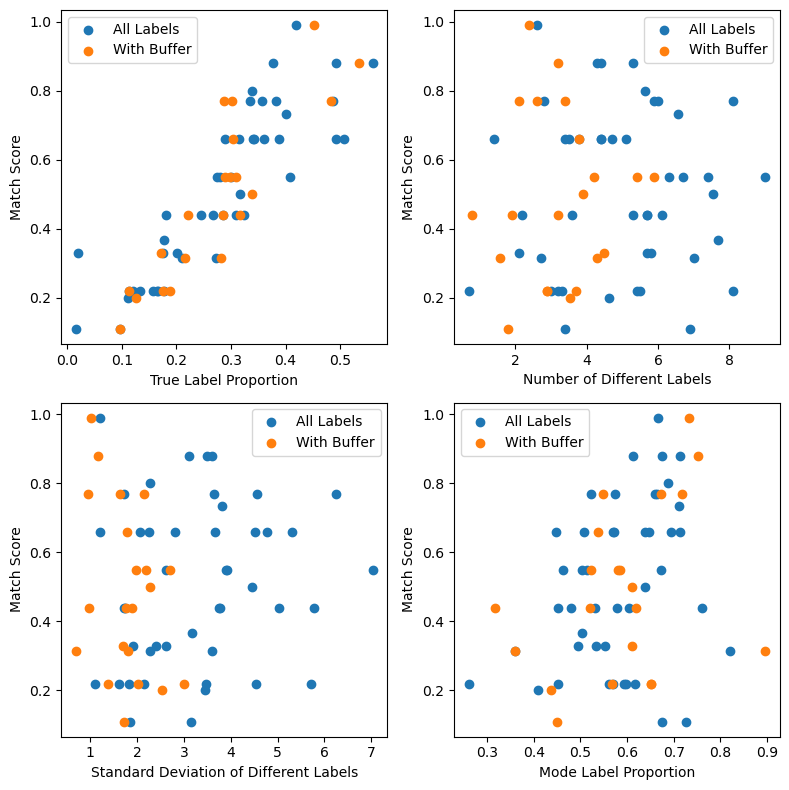

In [53]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged in 1 row and 3 columns
fig, axs = plt.subplots(2, 2, figsize=(8,8))

# First subplot
axs[0,0].scatter(df_all['true_label_proportion'], df_all['match_score'], label='All Labels')
axs[0,0].scatter(df_delay['true_label_proportion'], df_delay['match_score'], label='With Buffer')
axs[0,0].set_xlabel('True Label Proportion')
axs[0,0].set_ylabel('Match Score')
axs[0,0].legend()

# Second subplot
axs[0,1].scatter(df_all['number_different_labels'], df_all['match_score'], label='All Labels')
axs[0,1].scatter(df_delay['number_different_labels'], df_delay['match_score'], label='With Buffer')
axs[0,1].set_xlabel('Number of Different Labels')
axs[0,1].set_ylabel('Match Score')
axs[0,1].legend()

# Third subplot
axs[1,0].scatter(df_all['std_dev_different_labels'], df_all['match_score'], label='All Labels')
axs[1,0].scatter(df_delay['std_dev_different_labels'], df_delay['match_score'], label='With Buffer')
axs[1,0].set_xlabel('Standard Deviation of Different Labels')
axs[1,0].set_ylabel('Match Score')
axs[1,0].legend()

axs[1,1].scatter(df_all['mode_label_proportion'], df_all['match_score'], label='All Labels')
axs[1,1].scatter(df_delay['mode_label_proportion'], df_delay['match_score'], label='With Buffer')
axs[1,1].set_xlabel('Mode Label Proportion')
axs[1,1].set_ylabel('Match Score')
axs[1,1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()